Objectifs :
    
    - Appliquer la méthode de sous-échantillonage "downsampling"
    - Créer et entraîner un modèle d'arbre de décision
    - Afficher l'arbre de décision
    - Créer une grille de paramètres avec GridSearchCV pour rechercher les meilleures paramètres permettant d'améliorer les performances du modèle
    - Calculer l'importance des caractéristiques (features) dans cet arbre de décision
    - Utiliser des méthodes pour améliorer les performances du modèle basé sur l'arbre de décision :
    a) la méthode de boosting, avec le classifieur AdaBoost
    b) la technique de bagging avec l'utilisation du BaggingClassifier
    c) la technique Gradient Boosting (GradientBoostingClassifier)
    d) la méthode XGBoost (eXtreme Gradient Boosting)
    e) la méthode GradientBoostingRegressor
    f) un algorithme de boosting LightGBM (Light Gradient Boosting Machine) - tentative n'ayant pu aboutir
    g) un algorithme de boosting CatBoost (Categorical Boosting) - tentative n'ayant pu aboutir

Liste des difficultés rencontrées :


- Chargement du dataframe (trop volumineux)

-> Tentative : Utilisation de low_memory=True
Ce qui permet à pandas de traiter le fichier en utilisant une quantité minimale de mémoire, en particulier pour les colonnes avec des types de données variés. Cependant, cela a entraîné une utilisation plus intensive du processeur. L'opération a échoué.
-> Solution = Utilisation d'un dtype approprié : lors de la lecture du fichier CSV, spécification des types de données attendus pour chaque colonne en utilisant le paramètre dtype. Cela a réduit la consommation de mémoire + Utilisation de low_memory=False

- Plusieurs colonnes contiennent des valeurs de type chaîne de caractères et l'arbre de décision nécessite des données numériques.

-> Solution : utilisation de l'encodage one-hot (ou l'encodage de labels) pour convertir ces données catégorielles en données numériques.
L'encodage one-hot est approprié pour les modèles qui ne supposent pas d'ordre entre les catégories.
L'encodage par LabelEncoder n'est pas adapté ici car pas les variables ne supposent pas d'ordre spécifique.


- L'encodage one-hot avec pd.get_dummies() génère une matrice trop grande et dépasse la mémoire disponible

-> Solution : Sélection des colonnes catégorielles à encoder en utilisant la paramètre columns de la fonction pd.get_dummies().

- Le modèle d'arbre de décision ne peut pas traiter certaines données de type Timestamp.
Il s'agit des variables : 'an_nais', 'an_naiss', 'date'.

-> Solution : Supression de ces variables car pas utiles pour les prédictions. Nous disposons déjà de l'âge de l'accident, de l'année, du mois et du jour de la semaine.
Une autre solution aurait été la transformation en caractéristiques numériques appropriées pour les utiliser dans la modèle d'arbre de décision si elles avaient été utiles.


In [ ]:
# Import des packages
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import chi2_contingency

import matplotlib.pyplot as plt
%matplotlib inline


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import plot_tree
from sklearn.model_selection import GridSearchCV


In [ ]:
pip install missingno

Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable


In [ ]:
import missingno as msno

In [ ]:
dtype_dict = {
    'num_acc': 'int64',
    'place': 'category',
    'catu': 'category',
    'grav': 'category',
    'sexe': 'category',
    'trajet': 'category',
    'locp': 'category',
    'actp': 'category',
    'etatp': 'category',
    'num_veh': 'object',
    'secuUn': 'category',
    'secuDeux': 'category',
    'age_acc_an': 'float64',
    'tranches_ages': 'category',
    'catr': 'category',
    'circ': 'category',
    'nbv': 'float64',
    'vosp': 'object',
    'prof': 'category',
    'plan': 'category',
    'surf': 'category',
    'infra': 'object',
    'situ': 'category',
    'senc': 'category',
    'occutc': 'float64',
    'obs': 'category',
    'obsm': 'category',
    'choc': 'category',
    'manv': 'category',
    'catv_Label': 'category',
    'permis': 'category',
    'lum': 'category',
    'agg': 'category',
    'int': 'category',
    'atm': 'category',
    'col': 'category',
    'com': 'object',
    'dep': 'object',
    'jour_de_la_semaine': 'category',
    'heure': 'int64'
}

In [ ]:
# Spécification des colonnes à analyser comme dates avec parse_dates
date_columns = ['an_nais', 'an_naiss', 'date']

In [ ]:
# Lecture du fichier CSV en spécifiant les types de données et les colonnes à analyser comme dates
fusion = pd.read_csv('fusion3.csv', dtype=dtype_dict, parse_dates=date_columns, low_memory=False)


In [ ]:
fusion.head(10)

,Unnamed: 0,num_acc,place,catu,grav,sexe,trajet,locp,actp,etatp,...,lum,agg,int,atm,col,com,dep,date,jour_de_la_semaine,heure
0,0,200500000001,1.0,Conducteur,Blessé léger,Masculin,Domicile – travail,Sans objet,Non renseigné ou sans objet,Non renseigné,...,Nuit sans éclairage public,En agglomération,Hors intersection,Normale,Deux véhicules – par le coté,11,59,2005-01-12,Mercredi,19
1,1,200500000001,1.0,Conducteur,Blessé hospitalisé,Féminin,Courses – achats,Sans objet,Non renseigné ou sans objet,Non renseigné,...,Nuit sans éclairage public,En agglomération,Hors intersection,Normale,Deux véhicules – par le coté,11,59,2005-01-12,Mercredi,19
2,2,200500000001,2.0,Passager,Indemne,Masculin,Non renseigné,Sans objet,Non renseigné ou sans objet,Non renseigné,...,Nuit sans éclairage public,En agglomération,Hors intersection,Normale,Deux véhicules – par le coté,11,59,2005-01-12,Mercredi,19
3,3,200500000001,4.0,Passager,Indemne,Masculin,Non renseigné,Sans objet,Non renseigné ou sans objet,Non renseigné,...,Nuit sans éclairage public,En agglomération,Hors intersection,Normale,Deux véhicules – par le coté,11,59,2005-01-12,Mercredi,19
4,4,200500000001,5.0,Passager,Indemne,Masculin,Non renseigné,Sans objet,Non renseigné ou sans objet,Non renseigné,...,Nuit sans éclairage public,En agglomération,Hors intersection,Normale,Deux véhicules – par le coté,11,59,2005-01-12,Mercredi,19
5,5,200500000001,3.0,Passager,Indemne,Féminin,Non renseigné,Sans objet,Non renseigné ou sans objet,Non renseigné,...,Nuit sans éclairage public,En agglomération,Hors intersection,Normale,Deux véhicules – par le coté,11,59,2005-01-12,Mercredi,19
6,6,200500000002,1.0,Conducteur,Indemne,Masculin,Promenade – loisirs,Sans objet,Non renseigné ou sans objet,Non renseigné,...,Plein jour,En agglomération,Hors intersection,Normale,Deux véhicules - frontale,51,59,2005-01-21,Vendredi,16
7,7,200500000002,1.0,Conducteur,Blessé hospitalisé,Masculin,Promenade – loisirs,Sans objet,Non renseigné ou sans objet,Non renseigné,...,Plein jour,En agglomération,Hors intersection,Normale,Deux véhicules - frontale,51,59,2005-01-21,Vendredi,16
8,8,200500000003,1.0,Conducteur,Indemne,Masculin,Domicile – travail,Sans objet,Non renseigné ou sans objet,Non renseigné,...,Nuit sans éclairage public,Hors agglomération,Hors intersection,Pluie légère,Deux véhicules - frontale,51,59,2005-01-21,Vendredi,18
9,9,200500000003,1.0,Conducteur,Blessé hospitalisé,Masculin,Domicile – travail,Sans objet,Non renseigné ou sans objet,Non renseigné,...,Nuit sans éclairage public,Hors agglomération,Hors intersection,Pluie légère,Deux véhicules - frontale,51,59,2005-01-21,Vendredi,18


In [ ]:
# Nombre de lignes et de colonnes dans le dataframe
fusion.shape

(2291797, 44)

In [ ]:
fusion.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2291797 entries, 0 to 2291796
Data columns (total 44 columns):
 #   Column              Dtype         
---  ------              -----         
 0   Unnamed: 0          int64         
 1   num_acc             int64         
 2   place               category      
 3   catu                category      
 4   grav                category      
 5   sexe                category      
 6   trajet              category      
 7   locp                category      
 8   actp                category      
 9   etatp               category      
 10  an_nais             datetime64[ns]
 11  num_veh             object        
 12  secuUn              category      
 13  secuDeux            category      
 14  an_naiss            datetime64[ns]
 15  age_acc_an          float64       
 16  tranches_ages       category      
 17  catr                category      
 18  circ                category      
 19  nbv                 float64       
 20  vo

In [ ]:
fusion = fusion.drop(columns=['an_nais', 'an_naiss', 'date'])

In [ ]:
fusion = fusion.drop(columns=['com'])

In [ ]:
fusion.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2291797 entries, 0 to 2291796
Data columns (total 40 columns):
 #   Column              Dtype   
---  ------              -----   
 0   Unnamed: 0          int64   
 1   num_acc             int64   
 2   place               category
 3   catu                category
 4   grav                category
 5   sexe                category
 6   trajet              category
 7   locp                category
 8   actp                category
 9   etatp               category
 10  num_veh             object  
 11  secuUn              category
 12  secuDeux            category
 13  age_acc_an          float64 
 14  tranches_ages       category
 15  catr                category
 16  circ                category
 17  nbv                 float64 
 18  vosp                object  
 19  prof                category
 20  plan                category
 21  surf                category
 22  infra               object  
 23  situ                category
 24

In [ ]:
# Création d'un dictionnaire pour stocker les colonnes catégorielles et leurs valeurs uniques
categorical_columns = ['place', 'catu', 'sexe', 'trajet', 'locp', 'actp', 'etatp', 'num_veh',
                       'secuUn', 'secuDeux', 'tranches_ages', 'catr', 'circ', 'prof',
                       'plan', 'surf', 'infra', 'situ', 'senc', 'obs', 'obsm', 'choc',
                       'manv', 'catv_Label', 'permis', 'lum', 'agg', 'int', 'atm', 'col',
                       "dep", 'jour_de_la_semaine']

categorical_values = {}
for col in categorical_columns:
    categorical_values[col] = fusion[col].unique()

# Utilisation du dictionnaire pour effectuer l'encodage one-hot
encoded_fusion = pd.get_dummies(fusion, columns=categorical_columns)

# Affichage des premières lignes du DataFrame encodé
print(encoded_fusion.head())

   Unnamed: 0       num_acc                grav  age_acc_an  nbv  \
0           0  200500000001        Blessé léger   29.021918  2.0   
1           1  200500000001  Blessé hospitalisé   37.027397  2.0   
2           2  200500000001             Indemne   41.030137  2.0   
3           3  200500000001             Indemne    1.002740  2.0   
4           4  200500000001             Indemne    7.005479  2.0   

            vosp  occutc  heure  place_0.0  place_1.0  ...  dep_986  dep_987  \
0  Sans objet(0)     0.0     19          0          1  ...        0        0   
1  Sans objet(0)     0.0     19          0          1  ...        0        0   
2  Sans objet(0)     0.0     19          0          0  ...        0        0   
3  Sans objet(0)     0.0     19          0          0  ...        0        0   
4  Sans objet(0)     0.0     19          0          0  ...        0        0   

   dep_988  jour_de_la_semaine_Dimanche  jour_de_la_semaine_Jeudi  \
0        0                            0  

In [ ]:
encoded_fusion.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2291797 entries, 0 to 2291796
Columns: 559 entries, Unnamed: 0 to jour_de_la_semaine_Vendredi
dtypes: category(1), float64(3), int64(3), object(1), uint8(551)
memory usage: 1.3+ GB


In [ ]:
object_columns = encoded_fusion.select_dtypes(include='object').columns

# Affichage des colonnes de type 'object'
print(object_columns)

Index(['vosp'], dtype='object')


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Création d'une instance de LabelEncoder
label_encoder = LabelEncoder()

# Application de l'encodage à la colonne "vosp"
encoded_fusion['vosp'] = label_encoder.fit_transform(encoded_fusion['vosp'])

# Visualisation des données de la variable cible "grav"

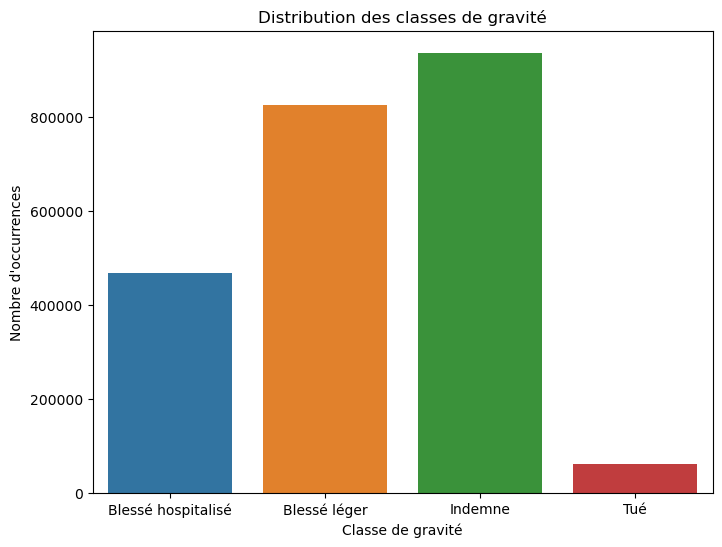

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Comptage des occurrences de chaque classe
class_counts = encoded_fusion['grav'].value_counts()

# Création d'un graphique à barres
plt.figure(figsize=(8, 6))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Distribution des classes de gravité')
plt.xlabel('Classe de gravité')
plt.ylabel('Nombre d\'occurrences')
plt.show()

In [ ]:
encoded_fusion["grav"].unique()

['Blessé léger', 'Blessé hospitalisé', 'Indemne', 'Tué']
Categories (4, object): ['Blessé hospitalisé', 'Blessé léger', 'Indemne', 'Tué']

# Application du sous-échantillonnage équilibré :

In [ ]:
from sklearn.utils import resample

# Comptage des occurrences de chaque classe de la variable cible "grav"
class_counts = encoded_fusion['grav'].value_counts()

# Identification de la classe majoritaire
majority_class = class_counts.idxmax()

# Calcul du nombre d'occurrences souhaité pour les autres classes de la variable cible "grav"
target_count = class_counts.min()  # Utilisation de la taille de la classe minoritaire

# Sous-échantillonnage pour chaque classe
undersampled_data = []
for cls in class_counts.index:
    cls_data = encoded_fusion[encoded_fusion['grav'] == cls]
    undersampled_cls_data = resample(cls_data, replace=False, n_samples=target_count, random_state=42)
    undersampled_data.append(undersampled_cls_data)

# Concaténation des données sous-échantillonnées
undersampled_data = pd.concat(undersampled_data)

# Mélange des données pour garantir l'ordre aléatoire
undersampled_data = undersampled_data.sample(frac=1, random_state=42)


# Vérification de l'absence de valeurs manquantes dans l'échantillon

In [ ]:
missing_values = undersampled_data.isnull().sum()
print(missing_values)

Unnamed: 0                     0
num_acc                        0
grav                           0
age_acc_an                     0
nbv                            0
                              ..
jour_de_la_semaine_Lundi       0
jour_de_la_semaine_Mardi       0
jour_de_la_semaine_Mercredi    0
jour_de_la_semaine_Samedi      0
jour_de_la_semaine_Vendredi    0
Length: 559, dtype: int64


In [ ]:
# Total des valeurs manquantes dans chaque colonne
total_missing = missing_values.sum()
print("Total des valeurs manquantes :", total_missing)

Total des valeurs manquantes : 0


In [ ]:
# Vérification s'il y a au moins une valeur manquante
if total_missing == 0:
    print("Il n'y a pas de valeurs manquantes.")
else:
    print("Il y a des valeurs manquantes dans le DataFrame.")

Il n'y a pas de valeurs manquantes.


# Création de l'arbre de décision et évalution du modèle :

In [ ]:
# Séparation des variables explicatives (features) de la variable cible (grav) parmi les données sous-échantillonnées
data = undersampled_data.drop(columns=['grav'])
target = undersampled_data['grav']

In [ ]:
# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

In [ ]:
# Création d'un modèle d'arbre de décision
tree_model = DecisionTreeClassifier(random_state=42)

In [ ]:
# Entraînement du modèle sur les données encodées
tree_model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [ ]:
# Prédictions sur l'ensemble de test
y_pred = tree_model.predict(X_test)

# Calcul de l'exactitude du modèle
accuracy = accuracy_score(y_test, y_pred)
print("Exactitude du modèle : {:.2f}%".format(accuracy * 100))

# Affichage du rapport de classification pour évaluer les performances par classe
print("Rapport de classification :\n", classification_report(y_test, y_pred))

Exactitude du modèle : 50.07%
Rapport de classification :
                     precision    recall  f1-score   support

Blessé hospitalisé       0.36      0.14      0.20     12319
      Blessé léger       0.41      0.61      0.49     12129
           Indemne       0.68      0.62      0.65     12211
               Tué       0.52      0.64      0.57     12286

          accuracy                           0.50     48945
         macro avg       0.49      0.50      0.48     48945
      weighted avg       0.49      0.50      0.48     48945



Les résultats obtenus montrent les performances du modèle avant l'ajustement des hyperparamètres:

- Exactitude du modèle : 50.07% signifie que le modèle prédit correctement la classe correcte environ la moitié du temps.
Une exactitude de 50,07% pour un modèle d'arbre de décision pourrait être considérée comme relativement basse.

- Le rapport de classification indique les métriques de performance pour chaque classe individuellement ainsi que les mesures agrégées:

  ** Precision (proportion des prédictions positives qui étaient correctes pour chaque classe) : le modèle a une précision qui oscille entre de 0.36 et 0,68% en fonction de la classe. Pour la classe "Blessé hospitalisé", la précision est de 0.36, ce qui signifie que parmi les échantillons prédits comme "Blessé hospitalisé", 36% sont effectivement de cette classe. Ce qui est le moins bon résultat.

  - Recall (proportion des instances réelles positives qui ont été correctement prédites par le modèle). Il oscille entre de 0.14 et 0,64% en fonction de la classe. Pour la classe "Blessé hospitalisé", le recall est de 0.14, ce qui signifie que le modèle a réussi à capturer uniquement 14% des exemples réels de cette classe.

  - F1-score (combinaison de la précision et du rappel en une seule métrique, permettant d'évaluer l'équilibre entre les deux) Étant donné que le F1-score est supérieur à 0.5 pour la plupart des classes, cela suggère que le modèle a une certaine capacité à discriminer entre les classes malgré les performances initiales. Toutefois, le F1-score de 0.20 pour la classe "Blessé hospitalisé" indique une performance modérée en termes d'équilibre entre précision et recall.

  - Support (nombre total d'instances réelles pour chaque classe) : il est équilibré en raison du sous-échantillonage effectué précédemment.

- Accuracy (proportion totale de prédictions correctes parmi toutes les prédictions). Elle est de 50%.

- Macro avg (moyenne des précisions, rappels et F1-scores pour toutes les classes).

- Weighted avg (moyenne pondérée des métriques par classe, où les poids sont déterminés par le nombre d'instances de chaque classe)

Globalement, les résultats montrent que le modèle initial a des performances limitées avec une précision et un rappel assez bas pour certaines classes.

Le modèle d'arbre de décision actuel ne parvient donc pas à bien généraliser sur les données de test.

Cela peut être dû à plusieurs raisons, telles que :
(1) des paramètres mal réglés,
(2) une insuffisance de données d'entraînement (ce qui est peu probable étant donné la taille du dataframe de départ
et donc du jeu d'entraînement)
(3) ou un déséquilibre de classe dans les données (ce qui est peu probable compte tenu de l'étape de sous-échantillonnage équilibré effectuée ci-avant)

L'ajustement des hyperparamètres devrait permettre d'améliorer les performances.

Affichage d'une matrice de confusion pour comparer les classes réelles et prédites :

In [ ]:
pd.crosstab(y_test, y_pred, rownames = ["classes réelles"], colnames = ["Classe prédite"])

Classe prédite,Blessé hospitalisé,Blessé léger,Indemne,Tué
classes réelles,,,,
Blessé hospitalisé,1698,5191,936,4494
Blessé léger,902,7342,2208,1677
Indemne,796,2654,7607,1154
Tué,1381,2567,479,7859


# Affichage de l'arbre de décision :

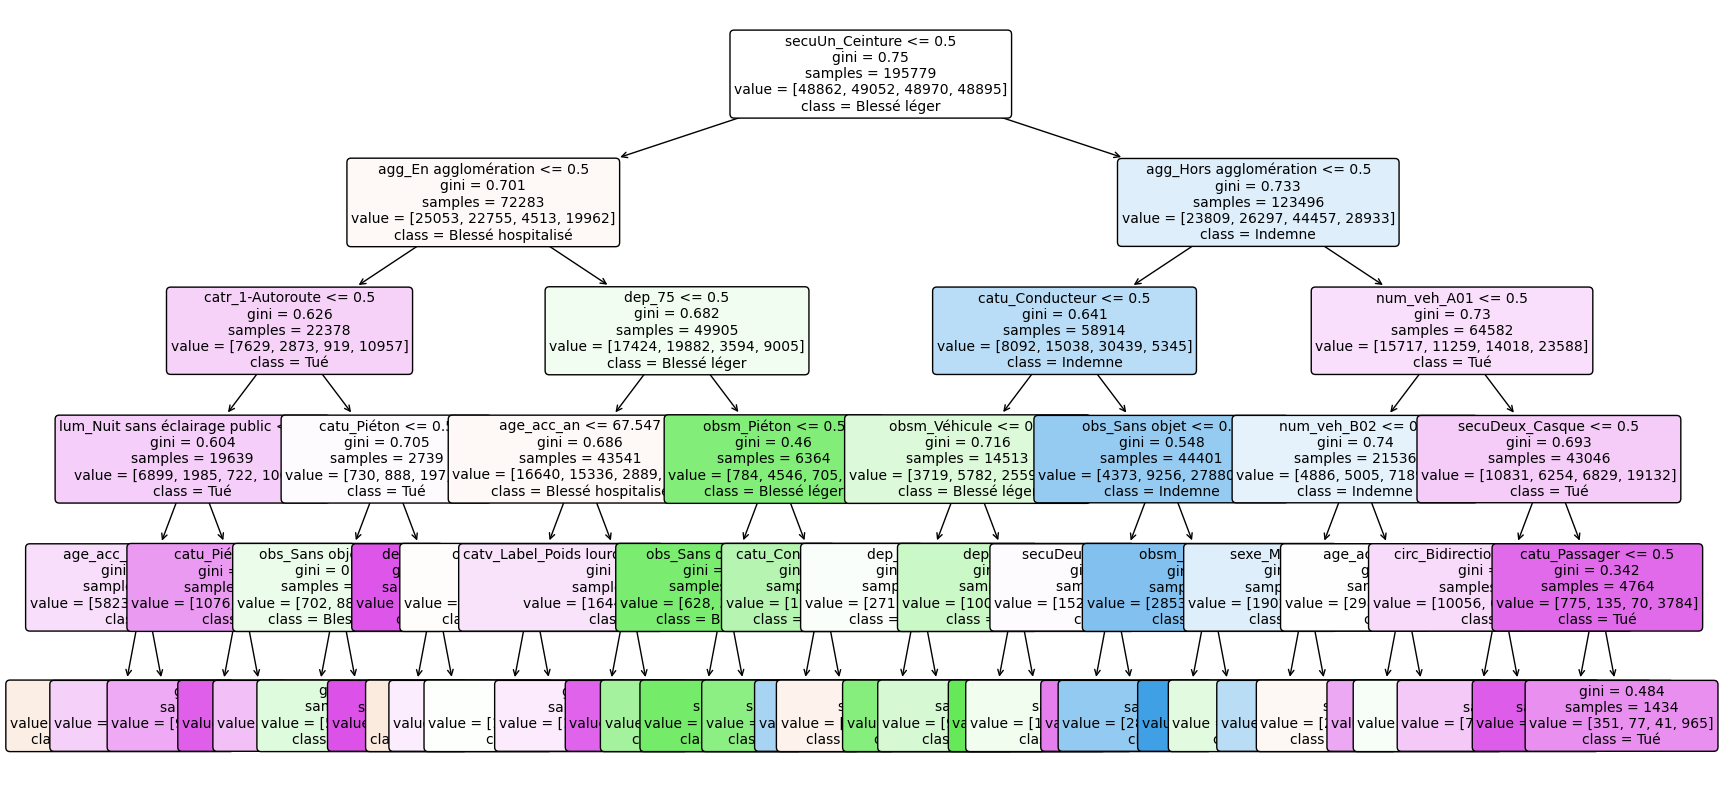

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Créer le modèle d'arbre de décision avec une limite de profondeur
tree_model = DecisionTreeClassifier(max_depth=5)

# Entraîner le modèle sur les données sous-échantillonnées
tree_model.fit(X_train, y_train)

# Afficher une partie de l'arbre jusqu'à la profondeur spécifiée
plt.figure(figsize=(20, 10))
plot_tree(tree_model, feature_names=data.columns, class_names=tree_model.classes_, filled=True, rounded=True, max_depth=5, fontsize=10)  # Augmentation de la taille de la police avec fontsize
plt.show()

In [ ]:
# Enregistrement du graphique en tant qu'image
plt.savefig('arbre_decision.png')

# Affichage du graphique
plt.show()

<Figure size 640x480 with 0 Axes>

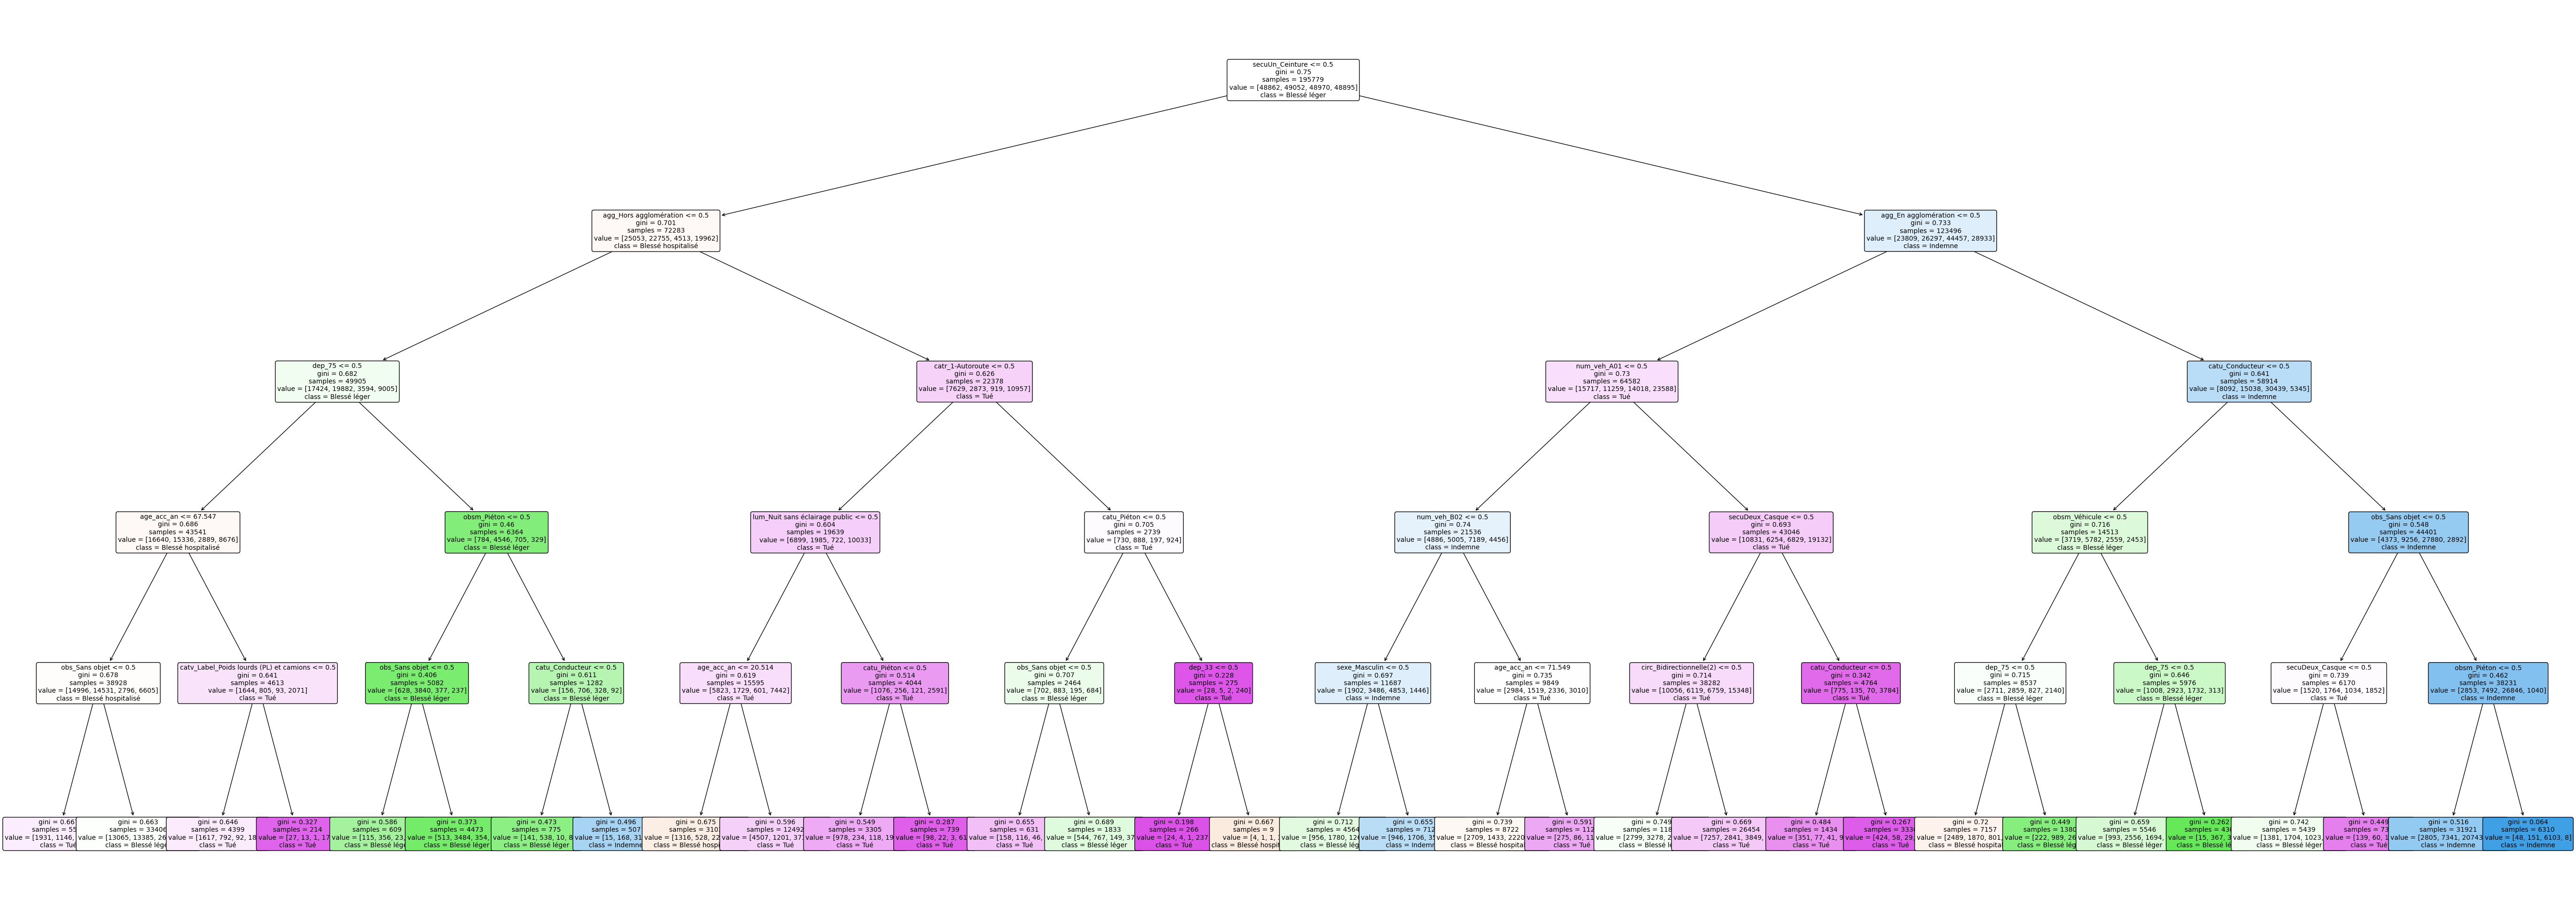

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Création du modèle d'arbre de décision avec une limite de profondeur
tree_model = DecisionTreeClassifier(max_depth=5)

# Entraînement du modèle sur les données sous-échantillonnées
tree_model.fit(X_train, y_train)

# Affichage d'une partie de l'arbre jusqu'à la profondeur spécifiée
plt.figure(figsize=(70, 25))
plot_tree(tree_model, feature_names=data.columns, class_names=tree_model.classes_, filled=True, rounded=True, max_depth=5, fontsize=10)  # Augmentez la taille de la police (par exemple, fontsize=10)
plt.show()

In [ ]:
# Enregistrement du graphique en tant qu'image
plt.savefig('arbre_decision.png')

# Affichage du graphique
plt.show()

<Figure size 640x480 with 0 Axes>

# Ajustement des hyperparamètres de l'arbre de décision :

Nous allons éssayer d'ajuster les hyperparamètres de l'arbre de décision pour trouver une configuration
qui améliore les performances du modèle.

Pour cela, nous allons utiliser la validation croisée pour évaluer les performances du modèle
avec différentes configurations d'hyperparamètres.

In [ ]:
# Définition d'une première grille de paramètres à explorer
param_grid_1 = {
    'max_depth': [None, 5], # Test de plusieurs profondeurs maximales de l'arbre (None signifie aucune limite)
    'min_samples_split': [2, 5], # Test de plusieurs nombre minimum d'échantillons requis pour diviser un nœud
    'min_samples_leaf': [1, 2],   # Test de plusieurs nombre minimum d'échantillons requis dans une feuille (nœud terminal)
    'criterion': ['gini', 'entropy'] # Critère de division ('gini' ou 'entropy')
}

# Choix de Gini pour mesurer l'impureté d'un nœud
# (si valeur de Gini plus basse indique que le nœud est plus pur,
# c'est-à-dire que les échantillons de la même classe sont plus concentrés)

# Choix de Entropie pour mesurer l'incertitude d'un nœud
# (si valeur d'entropie plus basse indique une répartition plus homogène des échantillons dans le nœud).


# Création d'un objet GridSearchCV pour pour la première recherche de grille
grid_search_1 = GridSearchCV(estimator=tree_model, param_grid=param_grid_1, cv=5, scoring='accuracy', n_jobs=-1)

# Recherche sur les données d'entraînement à partir de la première grille de recherche
grid_search_1.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(max_depth=5), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 5], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5]},
             scoring='accuracy')

In [ ]:
# Affichage des meilleurs paramètres trouvés pour la 1ère grille de recherche de grille
print("Meilleurs paramètres (1) :", grid_search_1.best_params_)

# Affichage de la meilleure précision obtenue pour la 1ère grille de recherche de grille
print("Meilleure précision (1) :", grid_search_1.best_score_)

Meilleurs paramètres (1) : {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}
Meilleure précision (1) : 0.4980207228869329


In [ ]:
import winsound
from IPython.display import display, Audio
import numpy as np

In [ ]:
# Définition d'une deuxième grille de paramètres à explorer
param_grid_2 = {
    'max_depth': [5, 15],
    'min_samples_split': [1, 2],
    'min_samples_leaf': [1],
    'criterion': ['gini', 'entropy']
}

# Création d'un objet GridSearchCV pour la seconde recherche de grille
tree_model = DecisionTreeClassifier()
grid_search_2 = GridSearchCV(estimator=tree_model, param_grid=param_grid_2, cv=5, scoring='accuracy', n_jobs=-1)

# Recherche sur les données d'entraînement à partir de la seconde grille de recherche
grid_search_2.fit(X_train, y_train)  # Assurez-vous d'avoir défini X_train et y_train

# Jouer le signal sonore
frequency = 440  # Fréquence du son en Hz
duration = 1.0  # Durée du son en secondes
t = np.linspace(0, duration, int(44100 * duration))
audio_data = np.sin(2 * np.pi * frequency * t)
display(Audio(audio_data, rate=44100))


In [ ]:
# Affichage des meilleurs paramètres trouvés pour la deuxième recherche de grille
print("Meilleurs paramètres (2) :", grid_search_2.best_params_)

# Affichage de la meilleure précision obtenue pour la deuxième recherche de grille
print("Meilleure précision (2) :", grid_search_2.best_score_)

Meilleurs paramètres (2) : {'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2}
Meilleure précision (2) : 0.5468002060955188


In [ ]:
# Définition d'une troisième grille de paramètres à explorer
param_grid_3 = {
    'max_depth': [20, 30],
    'min_samples_split': [2,3],
    'min_samples_leaf': [1],
    'criterion': ['gini', 'entropy']
}

# Création d'un objet GridSearchCV pour la seconde recherche de grille
grid_search_3 = GridSearchCV(estimator=tree_model, param_grid=param_grid_3, cv=5, scoring='accuracy', n_jobs=-1)

# Recherche sur les données d'entraînement à partir de la troisième grille de recherche
grid_search_3.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [20, 30], 'min_samples_leaf': [1],
                         'min_samples_split': [2, 3]},
             scoring='accuracy')

In [ ]:
# Affichage des meilleurs paramètres trouvés pour la troisième recherche de grille
print("Meilleurs paramètres (3) :", grid_search_3.best_params_)

# Affichage de la meilleure précision obtenue pour la troisième recherche de grille
print("Meilleure précision (3) :", grid_search_3.best_score_)

Meilleurs paramètres (3) : {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}
Meilleure précision (3) : 0.5322072315044215


In [ ]:
# Définition d'une quatrième grille de paramètres à explorer
param_grid_4 = {
    'max_depth': [16, 18],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'criterion': ['gini']
}

# Création d'un objet GridSearchCV pour la quatrième recherche de grille
grid_search_4 = GridSearchCV(estimator=tree_model, param_grid=param_grid_4, cv=5, scoring='accuracy', n_jobs=-1)

# Recherche sur les données d'entraînement à partir de la quatrième grille de recherche
grid_search_4.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini'], 'max_depth': [16, 18],
                         'min_samples_leaf': [1], 'min_samples_split': [2]},
             scoring='accuracy')

In [ ]:
# Affichage des meilleurs paramètres trouvés pour la quatrième recherche de grille
print("Meilleurs paramètres (4) :", grid_search_4.best_params_)

# Affichage de la meilleure précision obtenue pour la quatrième recherche de grille
print("Meilleure précision (4) :", grid_search_4.best_score_)

Meilleurs paramètres (4) : {'criterion': 'gini', 'max_depth': 16, 'min_samples_leaf': 1, 'min_samples_split': 2}
Meilleure précision (4) : 0.5439909091145088


In [ ]:
# Définition d'une cinquième grille de paramètres à explorer
param_grid_5 = {
    'max_depth': [15, 16],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'criterion': ['gini']
}

# Création d'un objet GridSearchCV pour la cinquième recherche de grille
grid_search_5 = GridSearchCV(estimator=tree_model, param_grid=param_grid_5, cv=5, scoring='accuracy', n_jobs=-1)

# Recherche sur les données d'entraînement à partir de la cinquième grille de recherche
grid_search_5.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini'], 'max_depth': [15, 16],
                         'min_samples_leaf': [1], 'min_samples_split': [2]},
             scoring='accuracy')

In [ ]:
# Affichage des meilleurs paramètres trouvés pour la cinquième recherche de grille
print("Meilleurs paramètres (5) :", grid_search_5.best_params_)

# Affichage de la meilleure précision obtenue pour la cinquième recherche de grille
print("Meilleure précision (5) :", grid_search_5.best_score_)

Meilleurs paramètres (5) : {'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2}
Meilleure précision (5) : 0.5470045152305003


In [ ]:
# Définition d'une sixième grille de paramètres à explorer
param_grid_6 = {
    'max_depth': [15],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'criterion': ['gini']
}

# Création d'un objet GridSearchCV pour la sixième recherche de grille
grid_search_6 = GridSearchCV(estimator=tree_model, param_grid=param_grid_6, cv=5, scoring='accuracy', n_jobs=-1)

# Recherche sur les données d'entraînement à partir de la quatrième grille de recherche
grid_search_6.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini'], 'max_depth': [15],
                         'min_samples_leaf': [1], 'min_samples_split': [2]},
             scoring='accuracy')

In [ ]:
# Affichage des meilleurs paramètres trouvés pour la sixième recherche de grille
print("Meilleurs paramètres (6) :", grid_search_6.best_params_)


Meilleurs paramètres (6) : {'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [ ]:
from sklearn.metrics import classification_report

# Affichage de la meilleure précision obtenue pour la sixième recherche de grille
print("Meilleure précision (6) :", grid_search_6.best_score_)

# Prédire les classes sur les données de test
y_pred_test = grid_search_6.predict(X_test)

# Afficher le rapport de classification pour les données de test
class_names = grid_search_6.classes_
report_test = classification_report(y_test, y_pred_test, target_names=class_names)
print("Rapport de classification pour les données de test :\n", report_test)


Meilleure précision (6) : 0.5469074659584895
Rapport de classification pour les données de test :
                     precision    recall  f1-score   support

Blessé hospitalisé       0.42      0.40      0.41     12319
      Blessé léger       0.52      0.47      0.49     12129
           Indemne       0.66      0.74      0.70     12211
               Tué       0.59      0.61      0.60     12286

          accuracy                           0.55     48945
         macro avg       0.55      0.55      0.55     48945
      weighted avg       0.55      0.55      0.55     48945



Avant l'ajustement des paramètres, l'exactitude du modèle était d'environ 50.07%, ce qui indique que le modèle avait du mal à bien généraliser et à faire des prédictions précises sur les données de validation.

Après l'ajustement des paramètres, nous obtenons une amélioration significative des performances.
L'exactitude du modèle est passée à environ 55%, et le rapport de classification montre une amélioration dans les scores de précision, de rappel et de F1-score pour chaque classe.
Cela signifie que le modèle ajusté parvient à mieux capturer les caractéristiques des différentes classes et à faire des prédictions plus précises.

Cependant, il y a toujours de la place pour l'amélioration.
Nous allons donc des techniques de validation croisée plus sophistiquées, comme la validation croisée stratifiée ou la validation croisée en série, pour évaluer plus précisément les performances du modèle.


Affichage d'une matrice de confusion pour comparer les classes réelles et prédites :

In [ ]:
pd.crosstab(y_test, y_pred, rownames = ["classes réelles"], colnames = ["Classe prédite"])

Classe prédite,Blessé hospitalisé,Blessé léger,Indemne,Tué
classes réelles,,,,
Blessé hospitalisé,1698,5191,936,4494
Blessé léger,902,7342,2208,1677
Indemne,796,2654,7607,1154
Tué,1381,2567,479,7859


Après avoir appliqué une recherche d'hyperparamètres pour optimiser le modèle d'arbre de décision, nous avons évalué sa performance en utilisant la matrice de confusion.

Voici les conclusions basées sur la matrice de confusion pour le modèle optimisé :

** Blessé hospitalisé (Blessé grave) :
Le modèle a correctement prédit un nombre de cas élevé de blessés hospitalisés (1698) et a réussi à capturer plus 42% des vrais cas.
Cependant, il a également prédit un nombre significatif de blessés légers (5191) comme blessés hospitalisés, indiquant une certaine confusion entre ces deux catégories.

** Blessé léger :
Le modèle a correctement prédit une grande majorité des cas de blessés légers (7342) avec une sensibilité de 48,8%.
Cependant, il a encore confondu certains blessés légers avec des blessés hospitalisés (2208 prédictions erronées).

** Indemne :
Le modèle a réussi à identifier un grand nombre d'individus indemnes (7607) avec une sensibilité élevé de 71,4%.
Il a également prédit certains individus indemnes (796) comme blessés hospitalisés, mais cela représente une amélioration par rapport aux blessés légers.

** Tué :
Le modèle a correctement prédit la grande majorité des individus tués (7859) avec une sensibilité de 51,7%.
Cependant, il a fait un nombre encore important d'erreurs en prédisant des individus tués notamment comme blessés légers (2567 prédictions erronées) et blessés hospitalisés (1381 prédictions erronées).

Le modèle d'arbre de décision, après avoir été optimisé avec des hyperparamètres, présente une meilleure performance qu'auparavant. Il a réussi à améliorer sa capacité à distinguer entre les différentes catégories, notamment pour les cas les plus graves (tués et blessés hospitalisés). Cependant, des erreurs de classification persistent, principalement entre les blessés légers et les blessés hospitalisés, bien que leur fréquence ait diminué par rapport au modèle non optimisé.


# Calcul de l'importance des caractéristiques (features) dans cet arbre de décision :

In [ ]:
feats = {}
for feature, importance in zip(data.columns, grid_search_6.best_estimator_.feature_importances_):
    feats[feature] = importance

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Importance'})
importances_sorted = importances.sort_values(by='Importance', ascending=False).head(60)

print(importances_sorted)


                                      Importance
agg_En agglomération                    0.148068
secuUn_Ceinture                         0.101682
obs_Sans objet                          0.063669
catu_Conducteur                         0.061022
age_acc_an                              0.056798
dep_75                                  0.032273
obsm_Piéton                             0.027708
num_veh_A01                             0.025896
Unnamed: 0                              0.023723
secuDeux_Casque                         0.022265
heure                                   0.018948
circ_Bidirectionnelle(2)                0.017752
num_veh_B02                             0.017067
sexe_Masculin                           0.014885
manv_Déporté - A gauche                 0.012127
catu_Piéton                             0.011701
col_Deux véhicules - frontale           0.011614
num_veh_B01                             0.010372
obsm_Véhicule                           0.009718
permis_Permis B     

Plus les valeurs sont élevées, plus la caractéristique a un impact sur les prédictions du modèle.

** agg_En agglomération :
La caractéristique indiquant si l'accident s'est produit en agglomération semble avoir le plus grand impact sur les prédictions du modèle.

** secuUn_Ceinture :
La présence de la ceinture de sécurité pour le conducteur (secuUn_Ceinture) est également un facteur important dans la prédiction.

** obs_Sans objet :
La caractéristique indiquant qu'il n'y a pas d'objet obstruant la voie semble avoir un impact significatif sur les prédictions.

** catu_Conducteur :
Le fait que l'usager accidenté est un conducteur (catu) est également un facteur important dans les prédictions.

** age_acc_an :
L'âge de l'usager au moment de l'accident semble avoir un impact important sur les prédictions.

** dep_75 :
Le fait que l'accident s'est produit ou non dans le département semble avoir un impact non négligeable sur les prédictions.

** obsm_Piéton :
La présence d'un piéton dans l'accident semble influencer les prédictions.

En conclusion, les facteurs liés aux lieux de l'accident (variables "agg", "dep"), à la sécurité des occupants (utilisation d'équipements de sécurité), à la présence d'obstacle sur la voie, au statut et à l'âge de l'usager accidenté et à l'implication ou non de piéton dans l'accident semblent avoir un impact significatif sur les prédictions du modèle.

Evaluation des performances du modèle avec les meilleurs paramètres en utilisant une validation croisée stratifiée afin d'obtenir une idée plus robuste de ses performances sur l'ensemble de données :

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier

In [ ]:
# Utilisation des meilleurs paramètres trouvés précédemment
best_params = {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'gini'}
tree_model = DecisionTreeClassifier(**best_params)

# Utilisation de la validation croisée stratifiée avec 5 plis
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


In [ ]:
# Calcul des scores de validation croisée
cross_val_scores = cross_val_score(tree_model, X_train, y_train, cv=stratified_cv, scoring='accuracy')

# Affichage des scores de validation croisée avec l'indication de la métrique utilisée
print("Scores de validation croisée (accuracy) :", cross_val_scores)
print("Score moyen (accuracy) :", cross_val_scores.mean())


Scores de validation croisée (accuracy) : [0.54637859 0.5452038  0.54438656 0.54280315 0.5473375 ]
Score moyen (accuracy) : 0.5452219191822698


Les scores de validation croisée obtenus indiquent les performances du modèle d'arbre de décision en utilisant la métrique d'exactitude (accuracy) sur 5 plis de données distincts.
Les scores varient de manière très faible d'un pli à l'autre.

Le score moyen de validation croisée indique que le modèle a une performance moyenne d'environ 54.52% en termes d'exactitude sur les données de validation croisée.

Les scores varient de manière très faible d'un pli à l'autre ce qui explique que les scores par pli et le score moyen sont quasiment identiques.

Analyse des rapports de classification à partir des résultats précédents :

In [ ]:
# Modèle après ajustement des paramètres
tree_model.fit(X_train, y_train)
y_pred = tree_model.predict(X_test)

# Rapport de classification
classification_rep = classification_report(y_test, y_pred, target_names=y_test.unique())
print("Rapport de classification après ajustement des paramètres :")
print(classification_rep)


Rapport de classification après ajustement des paramètres :
                    precision    recall  f1-score   support

Blessé hospitalisé       0.42      0.40      0.41     12319
      Blessé léger       0.52      0.47      0.49     12129
           Indemne       0.66      0.74      0.70     12211
               Tué       0.59      0.61      0.60     12286

          accuracy                           0.55     48945
         macro avg       0.55      0.55      0.55     48945
      weighted avg       0.55      0.55      0.55     48945



Globalement, la performance ne s'améliore pas.
Nous allons donc explorer d'autres algorithmes de classification, tels que les méthodes d'ensemble (Boosting et Bagging)

Affichage d'une matrice de confusion pour comparer les classes réelles et prédites :

In [ ]:
pd.crosstab(y_test, y_pred, rownames = ["classes réelles"], colnames = ["Classe prédite"])

Classe prédite,Blessé hospitalisé,Blessé léger,Indemne,Tué
classes réelles,,,,
Blessé hospitalisé,4909,2654,1404,3352
Blessé léger,2831,5660,2507,1131
Indemne,964,1546,9044,657
Tué,3051,964,760,7511


En comparant les résultats avant et après la validation croisée, les prédictions du modèle semblent avoir changé après l'application de la validation croisée, ce qui indique que les performances du modèle ont été réévaluées.

Les modifications dans la matrice de confusion n'ont visiblement pas eu un impact direct sur les métriques de précision, rappel et score F1 qui restent inchangées. Le modèle a donc dû ajuster les prédictions dans des proportions similaires pour toutes les classes, cela qui expliquerait la stabilité des métriques.

Calcul de l'importance des caractéristiques (features) dans cet arbre de décision :

In [ ]:
# Utilisation des meilleurs paramètres trouvés précédemment
best_params = {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'gini'}
tree_model = DecisionTreeClassifier(**best_params)

# Entraînement du modèle sur toutes les données d'entraînement
tree_model.fit(X_train, y_train)

# Extraction de l'importance des fonctionnalités
feats = {}
for feature, importance in zip(data.columns, tree_model.feature_importances_):
    feats[feature] = importance

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Importance'})
importances.sort_values(by='Importance', ascending=False).head(60)


,Importance
secuUn_Ceinture,0.101668
agg_Hors agglomération,0.101071
obs_Sans objet,0.063576
catu_Conducteur,0.061391
age_acc_an,0.056763
agg_En agglomération,0.046977
dep_75,0.032304
obsm_Piéton,0.027726
num_veh_A01,0.025751
Unnamed: 0,0.024532


Les résultats obtenus après avoir effectué la validation croisée montrent des différences dans l'importance des features par rapport aux résultats précédents.
Par exemple, "agg_Hors agglomération" a gagné en importance, tandis que "agg_En agglomération" a perdu de l'importance. Cela indique que le modèle ajusté attribue plus d'importance à certaines fonctionnalités par rapport à avant.

Malgré les changements, la plupart des fonctionnalités semblent avoir des valeurs d'importance relativement stables entre les deux configurations. Cela pourrait indiquer que la validation croisée n'a pas radicalement changé la hiérarchie des fonctionnalités.

Les résultats indiquent donc que la validation croisée a eu un impact sur l'importance attribuée aux fonctionnalités, mais cela n'a pas nécessairement entraîné des changements radicaux dans les performances globales du modèle.

# Boosting avec le classifieur AdaBoost :

Objectif : améliorer les performances du modèle en réduisant le bais du modèle d'arbre de décision pour convertir ce dernier en un modèle stable et puissant.

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import pandas as pd
import numpy as np


In [ ]:
Boosting = AdaBoostClassifier(estimator=tree_model, n_estimators=400)
Boosting.fit(X_train, y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=15),
                   n_estimators=400)

2023-08-27 17:15:12,598 - distributed.scheduler - WARNING - Worker failed to heartbeat within 300 seconds. Closing: <WorkerState 'tcp://127.0.0.1:54452', name: 2, status: running, memory: 0, processing: 0>
2023-08-27 17:15:12,746 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:54452'.
2023-08-27 17:15:15,433 - distributed.nanny - WARNING - Restarting worker


In [ ]:
Boosting.score(X_test, y_test)

0.5802431300439268

In [ ]:
y_pred = Boosting.predict(X_test)

In [ ]:
pd.crosstab(y_test, y_pred, rownames = ["classes réelles"], colnames = ["Classe prédite"])

Classe prédite,Blessé hospitalisé,Blessé léger,Indemne,Tué
classes réelles,,,,
Blessé hospitalisé,4810,2615,1068,3826
Blessé léger,2402,6276,2408,1043
Indemne,906,1781,8872,652
Tué,2657,786,401,8442


In [ ]:
# Calcul de l'exactitude du modèle
accuracy = accuracy_score(y_test, y_pred)
print("Exactitude du modèle : {:.2f}%".format(accuracy * 100))

# Affichage du rapport de classification pour évaluer les performances par classe
print("Rapport de classification :\n", classification_report(y_test, y_pred))

Exactitude du modèle : 58.02%
Rapport de classification :
                     precision    recall  f1-score   support

Blessé hospitalisé       0.45      0.39      0.42     12319
      Blessé léger       0.55      0.52      0.53     12129
           Indemne       0.70      0.73      0.71     12211
               Tué       0.60      0.69      0.64     12286

          accuracy                           0.58     48945
         macro avg       0.57      0.58      0.58     48945
      weighted avg       0.57      0.58      0.58     48945



In [ ]:
# Extraction de l'importance des fonctionnalités
feats = {}
for feature, importance in zip(data.columns, tree_model.feature_importances_):
    feats[feature] = importance

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Importance'})
importances.sort_values(by='Importance', ascending=False).head(60)


,Importance
secuUn_Ceinture,0.101668
agg_Hors agglomération,0.101071
obs_Sans objet,0.063576
catu_Conducteur,0.061391
age_acc_an,0.056763
agg_En agglomération,0.046977
dep_75,0.032304
obsm_Piéton,0.027726
num_veh_A01,0.025751
Unnamed: 0,0.024532


Les résultats montrent une amélioration des performances après l'application du boosting par rapport aux scores après application de la validation croisée et au rapport de classification initial.

- La précision moyenne globale était d'environ 54,5 % avant l'application du Boosting et 58% après.
- Le rapport de classification montre une amélioration des scores de précision, de rappel et de F1-score par classe.
- La matrice de confusion indique également une amélioration des prédictions pour certaines classes.

L'augmentation du score de précision globale et les améliorations dans le rapport de classification suggèrent que l'application du boosting a aidé le modèle à mieux généraliser et à améliorer ses prédictions par rapport aux données de test.

Les performances ont varié en fonction de chaque classe. Certaines classes (comme "Blessé hospitalisé" et "Indemne") ont montré une amélioration significative, tandis que d'autres classes (comme "Blessé léger") ont montré une amélioration modérée.

Les résultats indiquent une amélioration des performances après l'application du boosting, mais il nous allons poursuivre l'analyse et tester l'optimisation via l'application du bagging pour continuer à améliorer les performances du modèle.

# Bagging (BaggingClassifier) :

Objectif : améliorer les performances du modèle en réduisant la variance et en améliorant la généralisation du modèle en entraînant plusieurs instances du modèle sur des sous-ensembles aléatoires de données et en agrégeant leurs prédictions.

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
from sklearn.ensemble import BaggingClassifier

In [ ]:
# Reprise du modèle d'arbre de décision après réglage des hyperparamètres et de la validation croisée
tree_model = DecisionTreeClassifier(max_depth=15, min_samples_split=2, min_samples_leaf=1, criterion='gini')

# Création d'un modèle BaggingClassifier avec le modèle d'arbre de décision en tant qu'estimateur
bagging = BaggingClassifier(estimator=tree_model, n_estimators=100, random_state=42)

In [ ]:
# Entraînement du modèle
bagging_model.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=15),
                  n_estimators=100, random_state=42)

In [ ]:
# Prédiction sur les données de test
y_pred_bagging = bagging_model.predict(X_test)

In [ ]:
# Affichage du rapport de classification pour évaluer les performances
classification_rep_bagging = classification_report(y_test, y_pred_bagging, target_names=y_test.unique())
print("Rapport de classification après bagging :")
print(classification_rep_bagging)


Rapport de classification après bagging :
                    precision    recall  f1-score   support

Blessé hospitalisé       0.45      0.37      0.41     12319
      Blessé léger       0.56      0.50      0.53     12129
           Indemne       0.68      0.76      0.72     12211
               Tué       0.60      0.69      0.64     12286

          accuracy                           0.58     48945
         macro avg       0.57      0.58      0.58     48945
      weighted avg       0.57      0.58      0.58     48945



In [ ]:
# Calcul de l'exactitude du modèle
accuracy = accuracy_score(y_test, y_pred_bagging)
print("Exactitude du modèle : {:.2f}%".format(accuracy * 100))

Exactitude du modèle : 58.26%


In [ ]:
confusion_matrix = pd.crosstab(y_test, y_pred_bagging, rownames=["Classes réelles"], colnames=["Classe prédite"])
print(confusion_matrix)

Classe prédite      Blessé hospitalisé  Blessé léger  Indemne   Tué
Classes réelles                                                    
Blessé hospitalisé                4618          2649     1259  3793
Blessé léger                      2475          6095     2465  1094
Indemne                            747          1424     9297   743
Tué                               2350           794      637  8505


In [ ]:
feats = {}
for feature, importance in zip(data.columns, bagging_model.estimators_[0].feature_importances_):
    feats[feature] = importance

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Importance'})
importances_sorted = importances.sort_values(by='Importance', ascending=False)
print(importances_sorted.head(60))

                                        Importance
secuUn_Ceinture                           0.093769
agg_Hors agglomération                    0.092858
obs_Sans objet                            0.059231
age_acc_an                                0.058487
catu_Conducteur                           0.057864
agg_En agglomération                      0.043543
Unnamed: 0                                0.027671
dep_75                                    0.027653
num_veh_A01                               0.024394
obsm_Piéton                               0.023787
heure                                     0.021015
secuDeux_Casque                           0.020027
num_veh_B02                               0.015306
sexe_Masculin                             0.014593
circ_Bidirectionnelle(2)                  0.014060
catu_Piéton                               0.012804
col_Deux véhicules - frontale             0.011965
num_veh_B01                               0.010138
obsm_Véhicule                  

Nous constatons une légère amélioration de l'exactitude après l'application du Bagging par rapport au modèle de Boosting. L'exactitude est passée de 58.02% avec le Boosting à 58.26% avec le Bagging. Cela signifie que le Bagging a réussi à capturer davantage d'informations pour améliorer les prédictions.

Comparée à la matrice de confusion avant le Bagging, la matrice de confusion après le Bagging montre une légère amélioration dans la prédiction des classes, en particulier pour les classes "Blessé hospitalisé" et "Blessé léger".

Les importances des fonctionnalités semblent similaires avant et après le Bagging, avec des valeurs assez proches. Cela suggère que le Bagging n'a pas eu un impact majeur sur l'importance des fonctionnalités.

Bien que l'amélioration de l'exactitude soit modeste, il est important de noter que les modèles de Bagging et de Boosting ont permis d'améliorer légèrement les performances par rapport au modèle d'arbre de décision seul. Cela indique que la combinaison de plusieurs modèles (ensemble) a contribué à une meilleure généralisation et à une meilleure capture des relations entre les caractéristiques et les classes cibles.

Les résultats indiquent une légère amélioration des performances de prédiction avec l'utilisation du Bagging par rapport au modèle Boosting, et les importances des fonctionnalités restent relativement stables. Il peut être utile de continuer à expérimenter avec d'autres techniques pour obtenir de meilleures performances.

# Gradient Boosting (GradientBoostingClassifier) :

Le gradient boosting est une technique qui construit un modèle prédictif en ajustant de manière itérative les arbres de décision. Chaque nouvel arbre est ajusté pour corriger les erreurs du modèle précédent.

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
gradient_boost = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=3, random_state=None)
gradient_boost.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=1.0)

In [ ]:
y_pred_gb = gradient_boost.predict(X_test)

In [ ]:
# Calcul du score d'exactitude
accuracy = accuracy_score(y_test, y_pred_gb)
print("Score d'exactitude : {:.2f}%".format(accuracy * 100))

Score d'exactitude : 59.56%


In [ ]:
# Affichage de la matrice de confusion
pd.crosstab(y_test, y_pred_gb, rownames = ["classes réelles"], colnames = ["Classe prédite"])

Classe prédite,Blessé hospitalisé,Blessé léger,Indemne,Tué
classes réelles,,,,
Blessé hospitalisé,5025,2518,1165,3611
Blessé léger,2409,6403,2318,999
Indemne,805,1537,9309,560
Tué,2598,746,526,8416


In [ ]:
# Affichage du rapport de classification
class_report = classification_report(y_test, y_pred_gb)
print("Rapport de classification :")
print(class_report)

# XGBoost (eXtreme Gradient Boosting) :

In [ ]:
pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import xgboost as xgb

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Création d'un encodeur de labels
label_encoder = LabelEncoder()

# Aplication l'encodage aux données de la variable cible
y_train_encoded = label_encoder.fit_transform(y_train)

# Création du modèle XGBoost
xg_boost = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3)

In [ ]:
# Copie de X_train
X_train2 = X_train.copy()

# Suppression des caractères non valides de la copie
X_train2.columns = [col.replace('[', '').replace(']', '').replace('<', '') for col in X_train2.columns]


In [ ]:
xg_boost.fit(X_train2, y_train_encoded)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [ ]:
X_test2 = X_test.copy()

# Suppression des caractères non valides de la copie
X_test2.columns = [col.replace('[', '').replace(']', '').replace('<', '') for col in X_test2.columns]

In [ ]:
y_test_encoded = label_encoder.fit_transform(y_test)

In [ ]:
y_pred_xgb = xg_boost.predict(X_test2)

In [ ]:
# Calcul du score d'exactitude
accuracy = accuracy_score(y_test_encoded, y_pred_xgb)
print("Score d'exactitude : {:.2f}%".format(accuracy * 100))

Score d'exactitude : 56.73%


In [ ]:
# Affichage de la matrice de confusion
pd.crosstab(y_test_encoded, y_pred_xgb, rownames = ["classes réelles"], colnames = ["Classe prédite"])

Classe prédite,0,1,2,3
classes réelles,,,,
0,3912,2578,1595,4234
1,2174,5709,2901,1345
2,562,1203,9634,812
3,2048,840,886,8512


In [ ]:
# Affichage du rapport de classification
class_report = classification_report(y_test_encoded, y_pred_xgb)
print("Rapport de classification :")
print(class_report)

Rapport de classification :
              precision    recall  f1-score   support

           0       0.45      0.32      0.37     12319
           1       0.55      0.47      0.51     12129
           2       0.64      0.79      0.71     12211
           3       0.57      0.69      0.63     12286

    accuracy                           0.57     48945
   macro avg       0.55      0.57      0.55     48945
weighted avg       0.55      0.57      0.55     48945



# GradientBoostingRegressor (pour la régression) :

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
gradient_boost_reg = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=None)

In [ ]:
gradient_boost_reg.fit(X_train2, y_train_encoded)

GradientBoostingRegressor()

In [ ]:
y_pred_reg = gradient_boost_reg.predict(X_test2)

In [ ]:
from sklearn.metrics import r2_score

In [ ]:
# Calcul du score R²
r2 = r2_score(y_test_encoded, y_pred_reg)
print("Score R² : {:.2f}".format(r2))

Score R² : 0.15


Un R² de 0.15 indique que le modèle explique 15% de la variance totale des données.

# LightGBM (Light Gradient Boosting Machine) :

Modèle qui se caractérise par sa vitesse et son efficacité. Il utilise un histogramme basé sur le binning pour accélérer l'entraînement du modèle.

In [ ]:
pip install lightgbm

Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 1.3/1.3 MB 6.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install --upgrade lightgbm

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import lightgbm as lgb

In [ ]:
lightgbm = lgb.LGBMClassifier(n_estimators=100, learning_rate=0.1, max_depth=3)

In [ ]:
X_train3 = X_train.copy()
X_train3.columns = X_train3.columns.str.replace(' ', '_')

In [ ]:
X_train3.columns = ["".join(e for e in col if e.isalnum() or e == "_") for col in X_train3.columns]

In [ ]:
X_train3 = X_train3.rename(columns={'locp_Sur_chausséeA__50_m_du_passage_piéton': 'locp_Sur_chausséeA__50_m_du_passage_piéton_1',
                                   'locp_Sur_chausséeA__50_m_du_passage_piéton': 'locp_Sur_chausséeA__50_m_du_passage_piéton_2'})


In [ ]:
lightgbm.fit(X_train3, y_train)

In [ ]:
y_pred_lgbm = lightgbm.predict(X_test)

In [ ]:
# Calcul du score (exactitude) du modèle
accuracy = accuracy_score(y_test, y_pred_lgbm)
print("Score (Exactitude) : {:.2f}%".format(accuracy * 100))

In [ ]:
# Affichage de la matrice de confusion
pd.crosstab(y_test, y_pred_lgbm, rownames = ["classes réelles"], colnames = ["Classe prédite"])

In [ ]:
# Affichage du rapport de classification
classification_rep = classification_report(y_test, y_pred_lgbm)
print("Rapport de Classification :")
print(classification_rep)

# CatBoost (Categorical Boosting) :

Modèle qui gère automatiquement les variables catégorielles.

In [ ]:
pip install catboost

Defaulting to user installation because normal site-packages is not writeable
     -------------------------------------- 101.0/101.0 MB 7.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [ ]:
from catboost import CatBoostClassifier

In [ ]:
cat_boost = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=6, cat_features=[0, 1, 2])

In [ ]:
cat_boost.fit(X_train, y_train)

In [ ]:
y_pred_cbc= cat_boost.predict(X_test)

In [ ]:
# Calcul du score d'exactitude
accuracy = accuracy_score(y_test, y_pred_cbc)
print("Score d'exactitude : {:.2f}%".format(accuracy * 100))

In [ ]:
# Affichage de la matrice de confusion
pd.crosstab(y_test, y_pred_cbc, rownames = ["classes réelles"], colnames = ["Classe prédite"])

In [ ]:
# Affichage du rapport de classification
class_report = classification_report(y_test, y_pred_gb)
print("Rapport de classification :")
print(class_report)